In [1]:
# Modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

# Using PolynomialFeatures and make_pipeline for Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Data wrangling
import pandas as pd
import numpy as np
import re

# Time
import time
import datetime
from datetime import datetime as dt
import dateutil.parser

# Plotting
# import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import plt

# URL Grabbing
import requests

# Scraping / Searching
from bs4 import BeautifulSoup
import re

# Misc
import pickle
from pprint import pprint

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x) # reduces the amount of decimals when printing the df's

In [2]:
with open("movies.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [3]:
df.head().T

,0,1,2,3,4
index,The Other Side of the Mountain Part II,Universal Soldier,Newtown,Mommie Dearest,G.B.F.
actors,NaN,"[Jean-Claude Van Damme, Dolph Lundgren]",NaN,NaN,"[Natasha Lyonne, Megan Mullally]"
close_date,NaT,NaT,NaT,NaT,NaT
composers,NaN,[Tim Simonec],NaN,NaN,NaN
days_in_theater,NaN,NaN,14.00,NaN,NaN
directors,NaN,[Roland Emmerich],NaN,NaN,NaN
domestic_gross_adj,42753500.00,75661200.00,13900.00,59219100.00,NaN
foreign_unadj,NaN,NaN,NaN,NaN,NaN
genre,Romance,Sci-Fi Action,Documentary,Drama,Comedy
mpaa_rating,PG,R,Unrated,PG,R


In [4]:
# dropping all the multidimensional data, that will be engineered later
df_domestic_pred = df.drop(['actors', 'composers', 'directors', 'producers', 'writers'], 1)

# drop all the unadjusted data
df_domestic_pred = df_domestic_pred.drop(['foreign_unadj', 'worldwide_gross_unadj'], 1)

# dropping highly correlated data (and intertwined)
df_domestic_pred = df_domestic_pred.drop(['opening_weekend_adj'], 1)

In [5]:
df_domestic_pred.head().T

,0,1,2,3,4
index,The Other Side of the Mountain Part II,Universal Soldier,Newtown,Mommie Dearest,G.B.F.
close_date,NaT,NaT,NaT,NaT,NaT
days_in_theater,NaN,NaN,14.00,NaN,NaN
domestic_gross_adj,42753500.00,75661200.00,13900.00,59219100.00,NaN
genre,Romance,Sci-Fi Action,Documentary,Drama,Comedy
mpaa_rating,PG,R,Unrated,PG,R
number_of_theaters,NaN,1925.00,3.00,NaN,NaN
production_budget_adj,NaN,NaN,NaN,NaN,NaN
release_date,1978-01-01 00:00:00,1992-07-10 00:00:00,2016-10-07 00:00:00,1981-09-18 00:00:00,2014-01-17 00:00:00
runtime,100.00,102.00,85.00,129.00,93.00


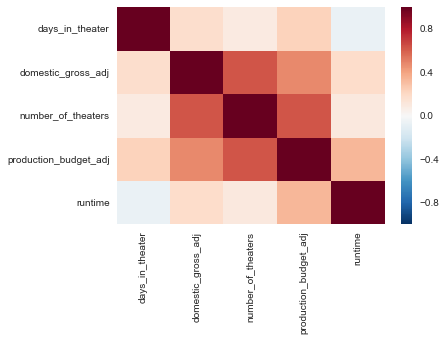

In [6]:
sns.heatmap(df_domestic_pred.corr());

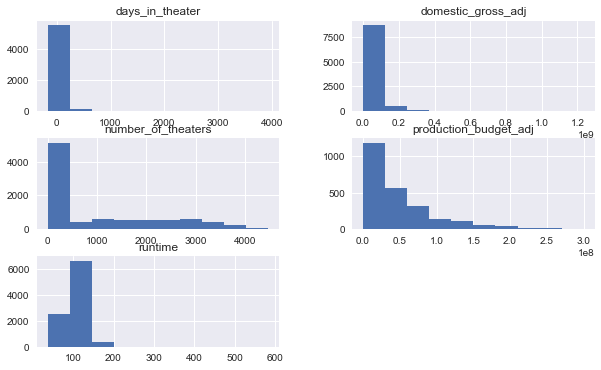

In [7]:
# need to do transformation on all of this
df_domestic_pred.hist(figsize=(10,6));

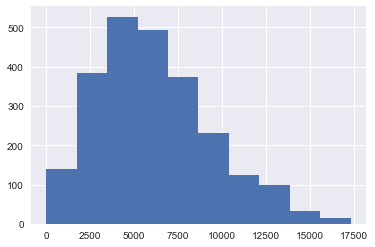

In [8]:
df_domestic_pred['production_budget_log'] = df_domestic_pred['production_budget_adj'].apply(np.sqrt)
df_domestic_pred.drop(['production_budget_adj'], 1)
df_domestic_pred['production_budget_log'].hist()

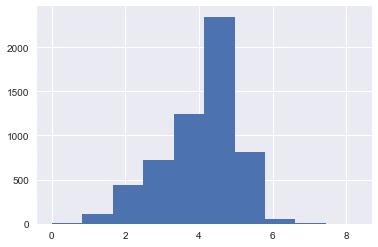

In [9]:
df_domestic_pred['days_in_theater_log'] = df_domestic_pred['days_in_theater'].apply(np.log)
df_domestic_pred.drop(['days_in_theater'], 1)
df_domestic_pred['days_in_theater_log'].hist()

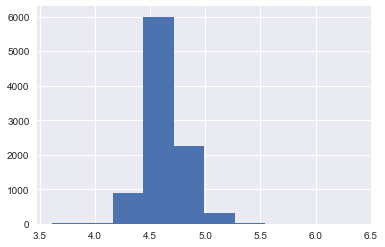

In [10]:
# df_domestic_pred['runtime'].apply(np.log).hist()
df_domestic_pred['runtime_log'] = df_domestic_pred['runtime'].apply(np.log)
df_domestic_pred.drop(['runtime'], 1)
df_domestic_pred['runtime_log'].hist();

In [11]:
# choose the predicted columns
df_domestic_pred = df_domestic_pred[['domestic_gross_adj', 'production_budget_log', 'runtime_log', 'days_in_theater_log', 'number_of_theaters']]

In [12]:
df_domestic_pred = df_domestic_pred.dropna(subset=['domestic_gross_adj', 'production_budget_log', 
                                                   'runtime_log', 'days_in_theater_log', 'number_of_theaters'])

In [13]:
df_domestic_pred.head()

,domestic_gross_adj,production_budget_log,runtime_log,days_in_theater_log,number_of_theaters
10,195732200.00,2236.07,4.70,4.34,3807.00
11,55815700.00,4472.14,4.70,4.34,2762.00
18,18664000.00,7745.97,4.62,4.25,2215.00
25,176014600.00,6557.44,4.76,5.12,3184.00
32,352178200.00,8602.33,4.51,5.08,4311.00


In [14]:
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df_domestic_pred.iloc[:, 1:]

# Choose the response variable(s)
y = df_domestic_pred.iloc[:, 0]

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.50369298053345657

In [15]:
plt.style.use('fivethirtyeight')

size = X.shape[0]

_1 = np.linspace(X.iloc[:,0].min(), X.iloc[:,0].max() + 1, size)
_2 = np.linspace(X.iloc[:,1].min(), X.iloc[:,1].max() + 1, size)
_3 = np.linspace(X.iloc[:,2].min(), X.iloc[:,2].max() + 1, size)
_4 = np.linspace(X.iloc[:,3].min(), X.iloc[:,3].max() + 1, size)

x_plot = np.matrix([_1,_2,_3,_4]).T

In [16]:
lr.predict(x_plot)

array([ -2.37487602e+08,  -2.37001060e+08,  -2.36514518e+08, ...,
         4.74322848e+08,   4.74809389e+08,   4.75295931e+08])

In [17]:
lr.predict(x_plot).shape
x_plot.T[0].T.shape

(1466, 1)

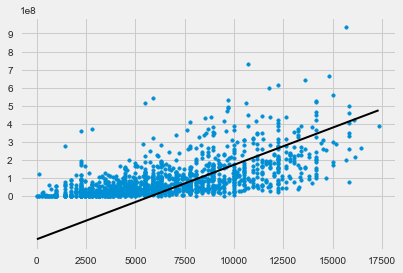

In [20]:
plt.scatter( df_domestic_pred['production_budget_log'], df_domestic_pred['domestic_gross_adj'], marker='.' )
plt.plot( x_plot.T[0].T, lr.predict(x_plot), linewidth=2, color='k' )
plt.yticks( np.arange(0,1000000000,100000000) );

In [ ]:
np.matrix([_1,_2,_3,_4]).T.shape

In [ ]:
lr.predict(x_plot).shape

In [ ]:
sns.lmplot('production_budget_log','domestic_gross_adj',
            data=df_domestic_pred[['domestic_gross_adj', 'production_budget_log']]);